In [1]:
from score import *
from keras.models import load_model

def hiarch_update(Y_i_hat, sub_hat, mods, weight=1.):
    sub_sum = np.sum(Y_i_hat[mods])
    Y_i_hat[mods] = weight * sub_sum * sub_hat + (1-weight)*Y_i_hat[mods]
    k = int(np.argmax(Y_i_hat))
    return Y_i_hat, k

def open_test_file(data_file):
    f = open(data_file, 'rb')
    testdata = pickle.load(f, encoding='latin1')
    testdata = np.stack([testdata[i] for i in range(1, len(testdata.keys())+1)], axis=0)
    return testdata

Using TensorFlow backend.


In [2]:
mod_group = 1
all_mods = [np.arange(24), np.array([1,9,10,11,12,13]), 
            np.array([4,5]), np.array([1,9]), np.array([6,7,20,21,22]), np.array([0,3]), np.array([0,3,6,7,20,21,22]),np.array([0,2,3,4,5,8,14,15,16,17,18,19,23])]
mods = all_mods[mod_group]

csv_path = './anom/train0_gp0.csv'
mod0_preds = get_pred(csv_path)
mod0_preds_copy = np.copy(mod0_preds)
labels = load_label('/bldata/army_challenge/training_data/training_data_chunk_0.pkl')

print('labels.shape', labels.shape)
# get all indices that classify as mod1 
mod0_labels = np.argmax(mod0_preds, axis = 1)
mod_one_idx = []

for i in mods:
    mod_one_idx.append(np.where(mod0_labels == i)[0])
mod_one_idx = np.concatenate(mod_one_idx)

mod_one_idx = np.arange(mod0_preds.shape[0])


mod1_model_path = '../models/gp1_1262_ens/model0.h5'
mod1_model = load_model(mod1_model_path)
mod1_model_path = '../models/gp1_large_ens/model0.h5'
mod1_model2 = load_model(mod1_model_path)

data = []
for i in range(3):
    data.append(open_test_file('/bldata/army_challenge/test_data/train0_part{}.pkl'.format(i+1)))

data = np.concatenate(data)


['./anom/train0_gp0.csv']
(288000, 24)
[Data Loader] - Loading Datafile,  /bldata/army_challenge/training_data/training_data_chunk_0.pkl (time series)
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Da

In [6]:
logloss, score = evaluate(mod0_preds, labels)
print(logloss, score)

0.503191545339562 66.52512137261296


In [3]:
preds = mod0_preds_copy
if True: 
    preds[:,19] = 0 #set PI4QPSK to 0
    subpreds = mod1_model.predict(data)
    subpreds2 = mod1_model2.predict(data)


In [14]:
EPS=1.e-6
for w1 in np.arange(0.7,1.0,0.1):
    for w2 in np.arange(0.5,1.0,0.1):
        preds = mod0_preds.copy()
        for i in range(0,preds.shape[0]):
            k = int(np.argmax(preds[i,:]))
            if True or k in mods:
                preds[i], k = hiarch_update(preds[i].copy(), subpreds2[i], mods, weight=w1)
            if True or k in mods:
                preds[i], k = hiarch_update(preds[i].copy(), subpreds[i], mods, weight=w2)

        if True: 
            preds = np.where(preds>EPS, preds, EPS)
            preds = np.where(preds<1-EPS, preds, 1-EPS)
            preds[:,19] = 0 #set PI4QPSK to 0
        preds /= np.sum(preds, axis=1, keepdims=True)
        logloss, score = evaluate(preds, labels)
        print(w1, w2, logloss, score)

0.7 0.5 0.4613635865465381 68.42924027983877
0.7 0.6 0.461451143550719 68.42514061540336
0.7 0.7 0.4619825116924629 68.40027100203481
0.7 0.7999999999999999 0.46309603796089027 68.34821324468182
0.7 0.8999999999999999 0.4651512637401856 68.25233849556501
0.7999999999999999 0.5 0.46018078812747454 68.4846704004641
0.7999999999999999 0.6 0.4604864810756444 68.47033594337023
0.7999999999999999 0.7 0.4612458101687072 68.43475567499117
0.7999999999999999 0.7999999999999999 0.46259726391189226 68.37152131170954
0.7999999999999999 0.8999999999999999 0.4649023094543211 68.26393770738895
0.8999999999999999 0.5 0.45920633469321864 68.53040424952914
0.8999999999999999 0.6 0.45967859851923454 68.50823195013247
0.8999999999999999 0.7 0.4606225065761947 68.46395940755923
0.8999999999999999 0.7999999999999999 0.4621748137162755 68.39127514844766
0.8999999999999999 0.8999999999999999 0.4646967602702913 68.27351757202376
0.9999999999999999 0.5 0.4586103751614912 68.55840442580728
0.9999999999999999 0.6

In [28]:
## inefficient way 

mod0_weights1 = np.arange(.0,1.05,0.1)
mod0_weights2 = np.arange(.0,1.05,0.1)


for lmbda in mod0_weights1:
   for lmbda2 in [0]:
        mod0_preds = np.copy(mod0_preds_copy)
        preds = np.copy(mod0_preds)
        for i,idx in enumerate(mod_one_idx):
            mod1 = np.empty(24)
            mod1[mods] =  mod1_preds[i]

            res, _ = hiarch_update(mod0_preds[idx], mod1_preds[i], mods, weight=lmbda)
            res, _ = hiarch_update(res, mod11_preds[i], mods2, weight=lmbda2)
            
            preds[idx] = res
        logloss, score = evaluate(preds, labels)
        print(lmbda, lmbda2, logloss, score)



0.0 0 0.503191545339562 66.52512137261296
0.1 0 0.49409161987762185 66.93029976849131
0.2 0 0.4877953259435504 67.21354628304175
0.30000000000000004 0 0.4827879475735356 67.44052658617979
0.4 0 0.4786697015505606 67.62835533529775
0.5 0 0.47526045626372626 67.78464072253517
0.6000000000000001 0 0.472476856691775 67.91278215718158
0.7000000000000001 0 0.47030178597269623 68.01324799714078
0.8 0 0.4687949983577072 68.08302051124375
0.9 0 0.46818550192624275 68.11128421361002
1.0 0 0.470333623512753 68.0117752874966


In [7]:
mod1_matrix = np.copy(mod0_preds_copy)
mod11_matrix = np.copy(mod0_preds_copy)
mod0_preds = np.copy(mod0_preds_copy)

print(mod1_matrix.shape)
for i,idx in enumerate(mod_one_idx):
    mod1, _ = hiarch_update(np.copy(mod0_preds[idx]), mod1_preds[i], mods, weight=1)
    mod1_matrix[idx] = mod1


(288000, 24)


In [27]:
mod0_preds = np.copy(mod0_preds_copy)
logloss, score = evaluate(mod0_preds, labels)

for lmbda in mod0_weights1:
    preds = lmbda * mod1_matrix + (1-lmbda) * mod0_preds
    logloss, score = evaluate(preds, labels)
    print(lmbda, logloss, score)

0.503191545339562 66.52512137261296
0.0 0.5031915453395618 66.52512137261297
0.1 0.4948239763995142 66.8975087226414
0.2 0.48893161868137514 67.1622516073383
0.30000000000000004 0.4841848257425546 67.37705322513916
0.4 0.48022463581171504 67.55731365406083
0.5 0.47688335250056485 67.71015451605325
0.6000000000000001 0.47407430928327204 67.83918515520581
0.7000000000000001 0.47175951463415455 67.94588314576495
0.8 0.46994319191820466 68.02983989436002
0.9 0.46868717364964463 68.08801887436856
1.0 0.4681855019262426 68.11128421361002


In [14]:
mod1_matrix = np.copy(mod0_preds_copy)
mod0_preds = np.copy(mod0_preds_copy)
for i, idx in enumerate(mod_one_idx):
    mod1, _ = hiarch_update(np.copy(mod0_preds[idx]), mod1_preds[i], mods, weight=0.9)
    mod1_matrix[idx] = mod1



In [15]:
logloss, score = evaluate(mod1_matrix, labels)
print(logloss, score)

0.46818550192624275 68.11128421361002


In [22]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(288000, 24)
(288000, 2, 1024) (288000, 24)


/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


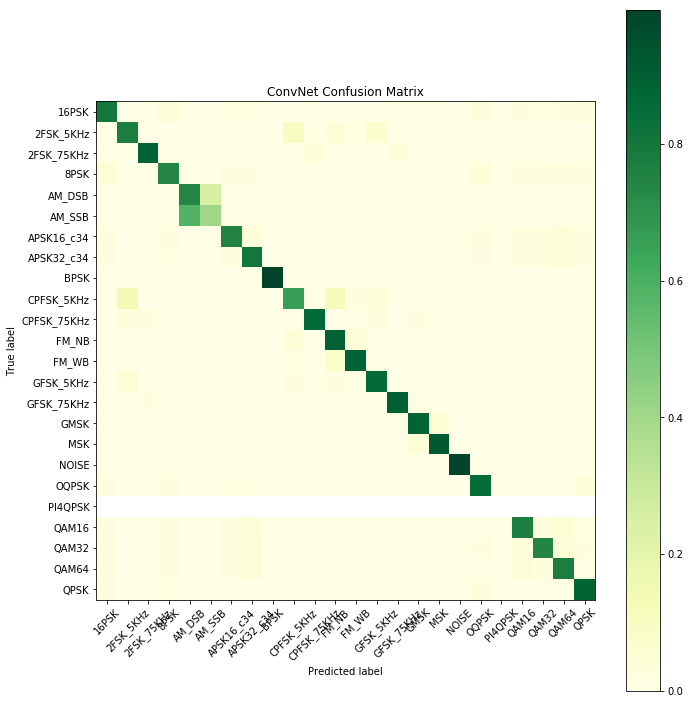

Overall Accuracy:  0.8157536231884058 Out of 288000


In [23]:
# estimate classes
classes = ['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB', 'APSK16_c34',
 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB',
 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16',
 'QAM32', 'QAM64', 'QPSK']


test_X_i = data #testdata.signalData[snr_bounded_test_indicies]
test_Y_i = labels #testdata.oneHotLabels[snr_bounded_test_indicies] 

print(test_Y_i.shape)
print(test_X_i.shape, test_Y_i.shape)

# estimate classes
test_Y_i_hat = mod1_matrix#model.predict(test_X_i)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,test_X_i.shape[0]):
    if np.sum(test_Y_i[i,:] > 0):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.figure(figsize=(10,10))
plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix")
plt.show()
cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy: ", cor / (cor+ncor), "Out of", data.shape[0])
acc = 1.0*cor/(cor+ncor)

In [13]:
print(acc)

0.8157536231884058
